Objectives

Business Question  - The client is interested in determining whether a particular leaf is infected or not.

Inputs

split_data/train
split_data/test
split_data/validation
created image embeddings

Outputs



Import packages

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

Set Directory

In [5]:
cwd= os.getcwd()

In [6]:
os.chdir('/workspaces/project5-mildrew')
print("You set a new current directory")

You set a new current directory


In [7]:
work_dir = os.getcwd()
work_dir

'/workspaces/project5-mildrew'

Set Input Directories

In [8]:
my_data_dir = 'split_data'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Reset Output Directory

In [9]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


Set the label to train images

In [10]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['powdery_mildew', 'healthy']


Get Image Shape from the previous data visualisation output

In [11]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

Plot the number of images in the train, validation and test sections

* train - powdery_mildew: 1262 images
* train - healthy: 1261 images
* validation - powdery_mildew: 420 images
* validation - healthy: 420 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images


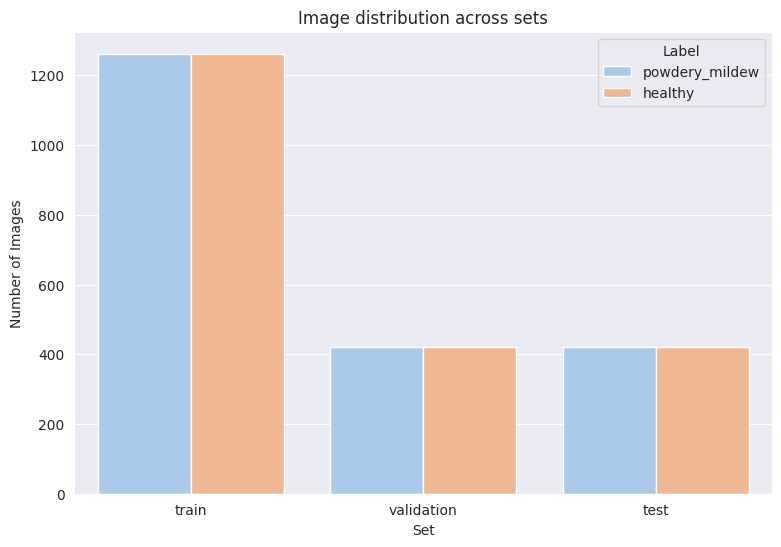

In [12]:
data = []
for folder in ['train', 'validation', 'test']:
    for label in labels:
        frequency = int(len(os.listdir(os.path.join(my_data_dir, folder, label))))
        data.append({'Set': folder, 'Label': label, 'Frequency': frequency})
        print(f"* {folder} - {label}: {frequency} images")

# Create dataframe
df_freq = pd.DataFrame(data)

# Plot number of images in each section
sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette='pastel')
plt.title('Image distribution across sets')
plt.ylabel('Number of Images')
plt.savefig(os.path.join(file_path, 'labels_distribution.png'), bbox_inches='tight', dpi=150)
plt.show()



Image Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Set Augmentation Parameters

In [14]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Apply augmentations on training image set

In [15]:
batch_size = 10
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2523 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Apply augmentations on validation image set

In [16]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 840 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Apply augmentations on test image set

In [17]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot Augmented Images (Validation & Test Set)

(10, 256, 256, 3)


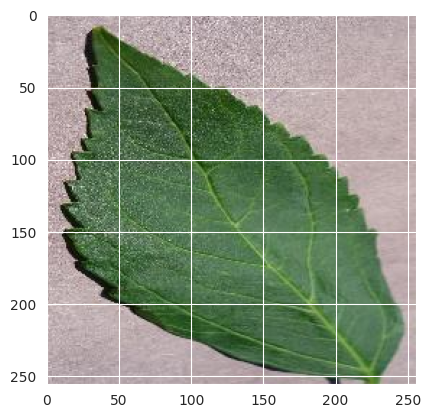

(10, 256, 256, 3)


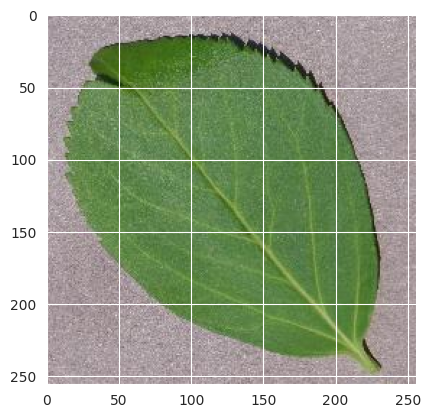

(10, 256, 256, 3)


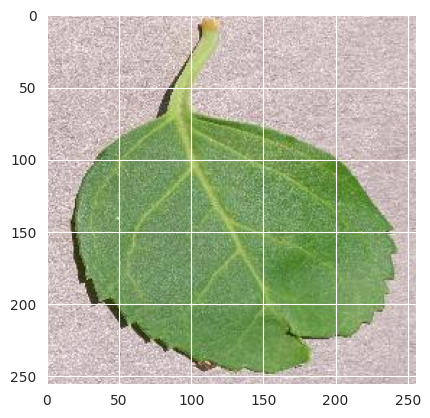

In [23]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

(10, 256, 256, 3)


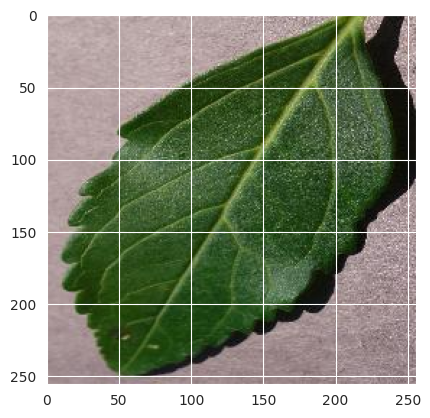

(10, 256, 256, 3)


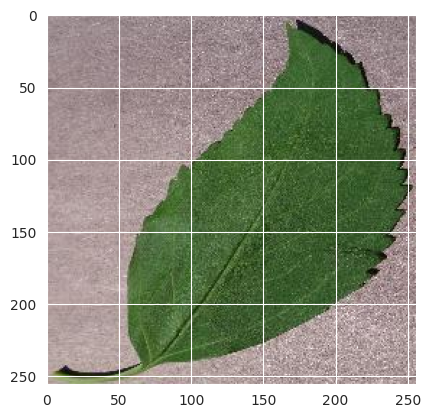

(10, 256, 256, 3)


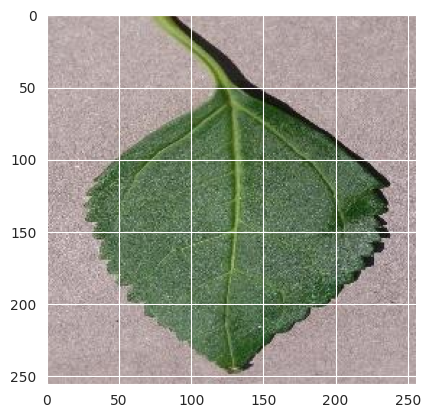

In [22]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Save class indices

In [24]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

Machine Learning Model

Import packages

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D